ARN = arn:aws:s3:::coleneemr
AWS_REGION = Europa (Frankfurt) eu-central-1

# First Time Test

In [88]:
#!pip install bs4

In [89]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import requests
from bs4 import BeautifulSoup
import re

INFO

#9 feature muss noch weiter gemacht werden.

In [90]:
script_dir = os.getcwd()
file_path = os.path.join(script_dir, "..", "JSONS", "all_matches.json")
#file_path = "/work/all_matches.json"
all_rows = []

In [91]:
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

for team_name, matches in data.items():
    for match in matches:
        try:
            info = match.get("info", {})
            game_id = info.get('gameId')
            game_mode = info.get("gameMode")
            game_type = info.get("gameType")
            timestamp = info.get("gameCreation")
            participants = info.get("participants", [])
            challenges = [participant.get("challenges", {}) for participant in participants]

            for player, challenge in zip(participants, challenges):
                row = {
                    "timestamp": timestamp,
                    "gameId": game_id,
                    "gameMode": game_mode,
                    "gameType": game_type,
                    "tier": player.get("tier"),
                    "rank": player.get("rank"),
                    "LP": player.get("leaguePoints"),
                    "wins": player.get("wins"),
                    "losses": player.get("losses"),
                }
                row.update(player)
                row.update(challenge)
                all_rows.append(row)

        except KeyError as e:
            print(f"Error {e} in {file_path}")
        except Exception as e:
            print(f"Error {e}")

df = pd.DataFrame(all_rows)

df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms')

#Open up dictionarys in the list and create columns:

ch_df = pd.json_normalize(df['challenges']).add_prefix('challenge_')

df = pd.concat([
    df.drop(columns=['challenges']),
    ch_df
], axis=1)

missions_df = pd.json_normalize(df['missions']).add_prefix('mission_')

df = pd.concat(
    [df.drop(columns=['missions']), missions_df],
    axis=1
)

perks_df = pd.json_normalize(df['perks']).add_prefix('perks_')

df = pd.concat(
    [df.drop(columns=['perks']), perks_df],
    axis=1
)

df = df[df['gameMode'] == 'CLASSIC']
df = df[df['tier'].isin(['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND'])]

df.tail()

,timestamp,gameId,gameMode,gameType,tier,rank,LP,wins,losses,PlayerScore0,...,mission_playerScore6,mission_playerScore7,mission_playerScore8,mission_playerScore9,mission_playerScore10,mission_playerScore11,perks_styles,perks_statPerks.defense,perks_statPerks.flex,perks_statPerks.offense
2103,2025-06-11 16:28:28.033,7429047723,CLASSIC,MATCHED_GAME,PLATINUM,IV,38,184.0,178.0,0.0,...,0.0,0.0,0.0,0,0,0,"[{'description': 'primaryStyle', 'selections':...",5001,5008,5005
2104,2025-06-11 16:28:28.033,7429047723,CLASSIC,MATCHED_GAME,PLATINUM,III,79,225.0,226.0,0.0,...,0.0,0.0,0.0,0,0,0,"[{'description': 'primaryStyle', 'selections':...",5001,5008,5005
2105,2025-06-11 16:28:28.033,7429047723,CLASSIC,MATCHED_GAME,SILVER,I,48,24.0,29.0,0.0,...,0.0,0.0,0.0,0,0,0,"[{'description': 'primaryStyle', 'selections':...",5001,5008,5008
2106,2025-06-11 16:28:28.033,7429047723,CLASSIC,MATCHED_GAME,GOLD,IV,48,141.0,145.0,0.0,...,0.0,0.0,0.0,0,0,0,"[{'description': 'primaryStyle', 'selections':...",5011,5008,5005
2107,2025-06-11 16:28:28.033,7429047723,CLASSIC,MATCHED_GAME,PLATINUM,IV,4,88.0,82.0,0.0,...,0.0,0.0,0.0,0,0,0,"[{'description': 'primaryStyle', 'selections':...",5001,5008,5008


In [92]:
with open('features_columns.json', 'w', encoding='utf-8') as f:
    json.dump(list(df.columns), f, ensure_ascii=False, indent=2)

In [93]:
print(df.isna().sum().sum())
#print(df.info)

28274


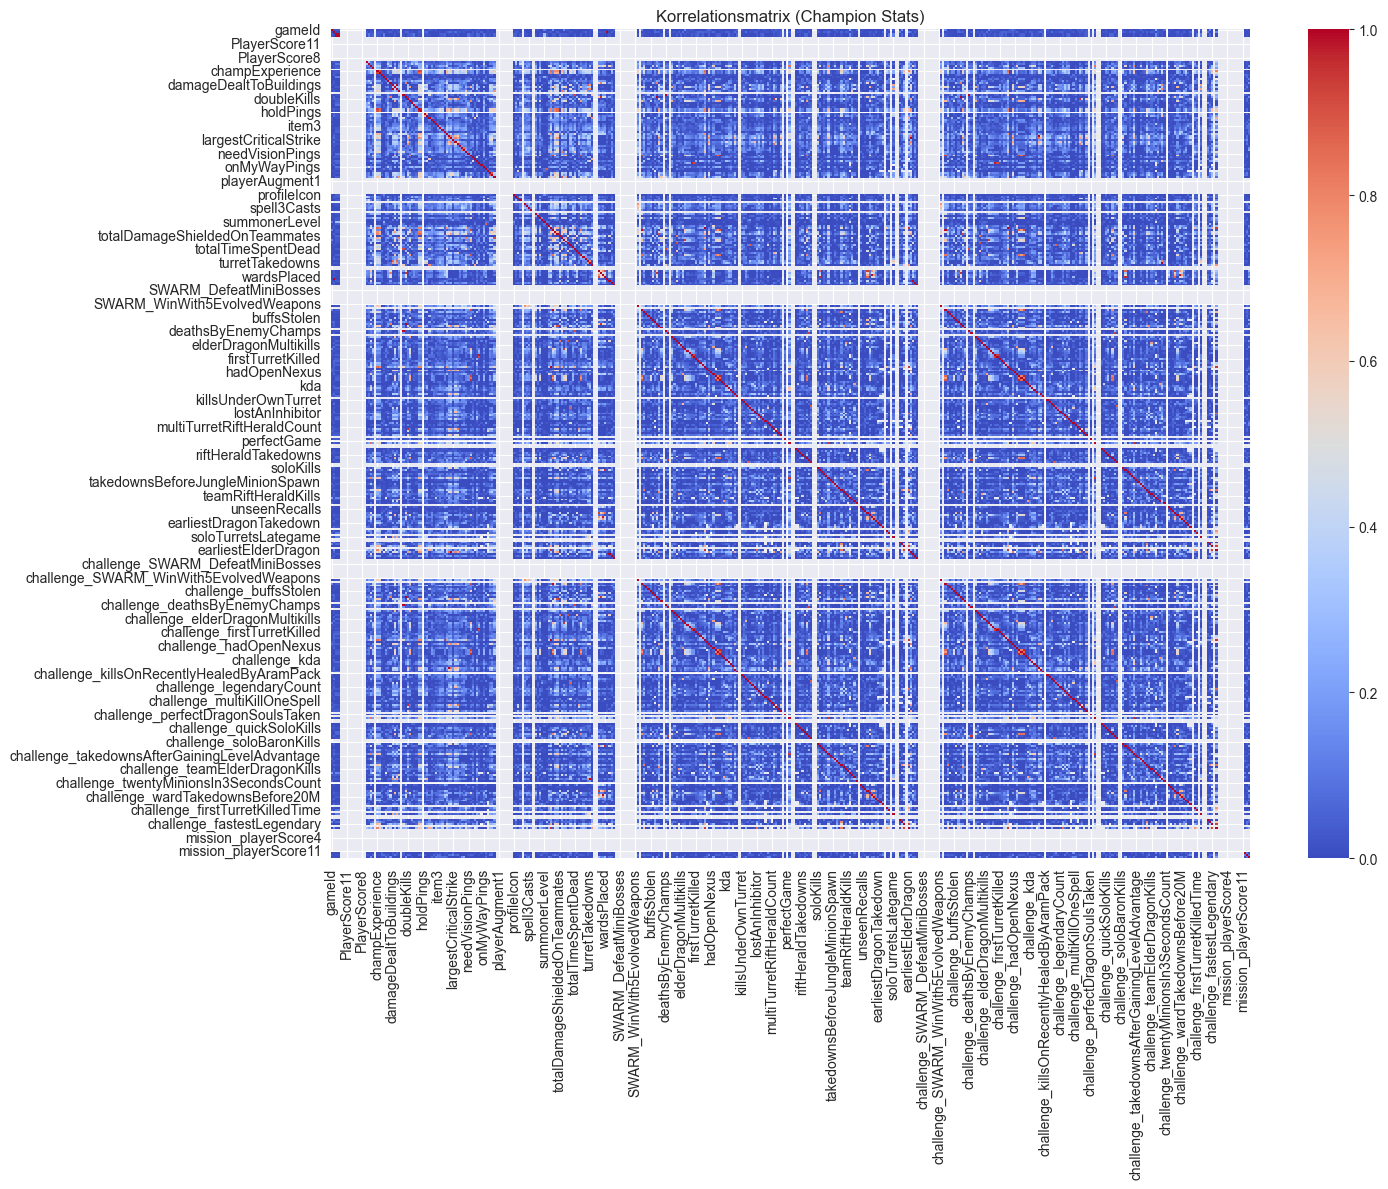

In [94]:
# Dropping non-numeric columns to compute the correlation matrix
numeric_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix for numerical columns
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix,
            annot=False,
            cmap="coolwarm",
            vmin=0,
            vmax=1,
            fmt=".3f",
            cbar=True
            )
plt.title("Korrelationsmatrix (Champion Stats)")
plt.tight_layout()
plt.show()

In [95]:
c_matrix = correlation_matrix.abs()
intervals = np.arange(0, 1.1, 0.1)
result = {round(i,1):[] for i in intervals}
result[1.1] = [] # NaN-Werte

cols = c_matrix.columns
n = len(cols)

for i in range(n):
    for j in range(i+1, n):
        v = c_matrix.iloc[i, j]
        if np.isnan(v):
            result[1.1].append((cols[i], cols[j]))
        else:
            bucket = round(np.floor(v * 10) / 10, 1)
            if v == 1.0:
                bucket = 1.0
            result[bucket].append((cols[i], cols[j]))

list_result = {k: v for k, v in result.items()}

with open('features_wertung.json', 'w', encoding='utf-8') as f:
    json.dump(list_result, f, ensure_ascii=False, indent=2)


In [96]:
# somtin somthin
'''
Features
DamageShare = teamDamagePercentage
role = lane
visionPerMinute = visionScorePerMinute
kda
totaltimespentdead
firstbloodkill
turretplatestaken
takedownsfirstxminutes
firstblood
kill-share
dodgeSkillShotsSmallWindow
outnumberedkills
veteran / freshBlood
hotStreak
perfectgame = deathless

longestTimeSpentLiving
quickCleanse
skillshotdogded
skillshotsHit
wardTakedownsBefore20M
gameEndedInEarlySurrender
maxlevelleadlaneopponent
summonerlevel
maxcsadvantageonlaneopponent
visionscoreadvantageonlaneopponent


'''


'''
heuristische Features
+1 Game Length vs. Winrate --> viele Games mit kurzer Zeit (normale Low Elo sind 30-40 Min)
+2 Account Level --> niedriges Level mit stark guten Stats ++
+3 Rank Progression (von Iron zu Gold in unter <50 Spielen)
-4 Durchschnittliches Gold vor 10 Minutes (vllt goldPerMinute anschauen und hohe Zahlen als Threshold verwenden)
-5 Anteil der Spiele mit S-Rank (kann OTP sein) Annäherungsversuch mittels Heuristik möglich --> S-Rank Potenzial Funktion
+6 Wie viele Perfekte Games (keine Tode)
+7 durchschnittlicher CS-Lead zum Lane Opponent (maxCsAdvantageOnLaneOpponent) ++
+8 hohe Vision Control ++
+9 durchschnittliches Gold pro Minute bei Champ und Rolle
+10 Zeit bis first full Item
-11 Erster Level 6 bei 10+ Games im Durchschnitt
+12 Winrate mit Off-Meta Champions (https://lolalytics.com/lol/tierlist/) --> All tierlist websites are dynamic (difficult to scrape)
+13 Anteil der Spiele mit über 20 Kills
-14 Ragequits/AFK-Quote (Smurf AFKt nicht)
-15 Keine frühen Aufgaben (earlysurrender gibt es nicht)
-16 Durchschnittliche Tower Damage im Verhältnis zum Team -->nur damageDealtToBuildings
+17 Durchschnittliche Anzahl an "Skillshots landed" ++
+18 Durchschnittliche Objective Steals pro Spiel
-19 Elo-Boosting (Drastische Veränderung der Account-Performance)
-20 Champion Experience (Viele S-Ranks ohne Championmastery oder wenige Punkte) - champion-mastery-v4-api
+21 Erst Prüfen ob "eligibleForProgression" ist auf "True" !!!

Info
--> mind 10+ Games für Aussagekraft
--> immer Top 5% der Elo-Rangliste
--> Alle Thresholds müssen aktualisiert werden mit einem Machine Learning Algorithmus

'''

'\nheuristische Features\n+1 Game Length vs. Winrate --> viele Games mit kurzer Zeit (normale Low Elo sind 30-40 Min)\n+2 Account Level --> niedriges Level mit stark guten Stats ++\n+3 Rank Progression (von Iron zu Gold in unter <50 Spielen)\n-4 Durchschnittliches Gold vor 10 Minutes (vllt goldPerMinute anschauen und hohe Zahlen als Threshold verwenden)\n-5 Anteil der Spiele mit S-Rank (kann OTP sein) Annäherungsversuch mittels Heuristik möglich --> S-Rank Potenzial Funktion\n+6 Wie viele Perfekte Games (keine Tode)\n+7 durchschnittlicher CS-Lead zum Lane Opponent (maxCsAdvantageOnLaneOpponent) ++\n+8 hohe Vision Control ++\n+9 durchschnittliches Gold pro Minute bei Champ und Rolle\n+10 Zeit bis first full Item\n-11 Erster Level 6 bei 10+ Games im Durchschnitt\n+12 Winrate mit Off-Meta Champions (https://lolalytics.com/lol/tierlist/) --> All tierlist websites are dynamic (difficult to scrape)\n+13 Anteil der Spiele mit über 20 Kills\n-14 Ragequits/AFK-Quote (Smurf AFKt nicht)\n-15 Kein

In [97]:
#New Features
df["damagePerGold"] = df["totalDamageDealtToChampions"] / df["goldEarned"]
df["carryScore"] =  (df["kda"] * df["totalDamageDealtToChampions"] * df["goldEarned"]) /  (df["timePlayed"]/60)
df["efficiencyScore"] = df["kda"] * df["damagePerGold"] * df["visionScorePerMinute"]

tier_map = {
    "IRON": 1,
    "BRONZE": 2,
    "SILVER": 3,
    "GOLD": 4,
    "PLATINUM": 5,
    "EMERALD": 6,
    "DIAMOND": 7,
    "MASTER": 8,
    "GRANDMASTER": 9,
    "CHALLENGER": 10,
    "UNRANKED": 0
}

rank_map = {"IV": 1, "III": 2, "II": 3, "I": 4}

df["tier_num"] = df["tier"].map(tier_map)
df["rank_num"] = df["rank"].map(rank_map).fillna(0).astype(int)

df["tier_score"] = df["tier_num"] + df["rank_num"] + df["LP"]/100

df_ranked = df[df["tier_score"] > 0].copy() #Filter non ranked players

df_ranked["kda_tier"] = df_ranked["kda"] / df_ranked["tier_score"]

df_ranked["winrate"] = df_ranked["wins"] / df_ranked["losses"]

df_ranked = df_ranked[df_ranked["eligibleForProgression"] == True].copy()

print(df_ranked["winrate"])

# Definiert wurde: Winrate, KDA/rank, damagePerGold, carryScore, efficiencyScore

21      0.797468
24      0.607143
25      0.853659
26      1.158416
28      1.129032
          ...   
2103    1.033708
2104    0.995575
2105    0.827586
2106    0.972414
2107    1.073171
Name: winrate, Length: 961, dtype: float64


# Heuristische Features implementieren

In [98]:
#1. Game Length vs. Winrate
# timePlayed und gameLength ist das Gleiche nur gameLength ist float (genauer?)

def compute_fast_winrate(df):
    shortgame_threshold = 25 * 60 # Für Sekunden!

    won_games = df[df['win'] == True]
    short_wins = won_games[won_games['gameLength'] < shortgame_threshold]

    all_fast_games = df[df['gameLength'] < shortgame_threshold]

    total_games = len(df)
    fast_winrate = len(short_wins) / len(won_games) if len(won_games) > 0 else 0
    fast_game_rate = len(all_fast_games) / total_games if total_games > 0 else 0

    return pd.Series({'winrate': fast_winrate, 'fast_game_rate': fast_game_rate})

df_fast_stats = df.groupby('puuid').apply(compute_fast_winrate).reset_index()

df_ranked = df_ranked.merge(df_fast_stats[['puuid', 'fast_game_rate']], on='puuid', how='left')


'''
if len(won_games) > 0:
    winrate = len(short_wins) / len(won_games)
else:
    winrate = None

print(f"Anteil schneller Siege (<{shortgame_threshold} min): {winrate:.2%}")
print(f"Anteil aller kurzen Spiele (<{shortgame_threshold} min): {len(all_fast_games) / len(df):.2%}")
'''

C:\Users\Emret\AppData\Local\Temp\ipykernel_10620\954101762.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_fast_stats = df.groupby('puuid').apply(compute_fast_winrate).reset_index()


'\nif len(won_games) > 0:\n    winrate = len(short_wins) / len(won_games)\nelse:\n    winrate = None\n\nprint(f"Anteil schneller Siege (<{shortgame_threshold} min): {winrate:.2%}")\nprint(f"Anteil aller kurzen Spiele (<{shortgame_threshold} min): {len(all_fast_games) / len(df):.2%}")\n'

In [99]:
#2. Account Level au smurf und score überprüfen
low_level_threshold = 50
high_kda_threshold = 4
high_winrate_threshold = 70
gold_earned_threshold = 400
totalDamageDealt_threshold = 300

account_stats = df_ranked.groupby('puuid').agg({
    'summonerLevel': 'first',
    'kda': 'mean',
    'kills': 'mean',
    'assists': 'mean',
    'deaths': 'mean',
    'goldPerMinute': 'mean',
    'totalDamageDealtToChampions': 'mean',
    'tier_num': 'first',
    'winrate' : 'mean'
}).reset_index()

account_stats['smurf_flag'] = (
    (account_stats['summonerLevel'] < low_level_threshold) &
    (
        #(account_stats['kda'] >= high_kda_threshold) &
        #(account_stats['kills'] >= 8) &
        #(account_stats['goldPerMinute'] >= gold_earned_threshold) &
        #(account_stats['totalDamageDealtToChampions'] >= totalDamageDealt_threshold) &
        (account_stats['winrate'] >= high_winrate_threshold)
    )
)

account_stats['smurf_score'] = (
    (account_stats['summonerLevel'] < low_level_threshold).astype(int) +
    #(account_stats['kda'] >= high_kda_threshold).astype(int) +
    #(account_stats['kills'] >= 8).astype(int) +
    #(account_stats['goldPerMinute'] >= gold_earned_threshold).astype(int) +
    #(account_stats['totalDamageDealtToChampions'] >= totalDamageDealt_threshold).astype(int) +
    (account_stats['winrate'] >= high_winrate_threshold).astype(int)
)

account_stats['smurf_ratio'] = account_stats['smurf_score'] / account_stats['tier_num']
account_stats['smurf_ratio'] = account_stats['smurf_ratio'].fillna(0)

df_ranked = df_ranked.merge(account_stats[['puuid', 'smurf_flag', 'smurf_score', 'smurf_ratio']], on='puuid', how='left')

#print(df_ranked[['puuid', 'summonerLevel', 'kda', 'win', 'kills', 'goldPerMinute', 'totalDamageDealtToChampions', 'smurf_flag', 'smurf_score', 'smurf_ratio']].head())

print(df_ranked[['puuid', 'summonerLevel', 'kda', 'winrate', 'kills', 'goldPerMinute', 'totalDamageDealtToChampions', 'smurf_flag', 'smurf_score', 'smurf_ratio']].head())

                                               puuid  summonerLevel       kda  \
0  t1wLPAdlaN1kGqSczdNGQM0QSX6YCUcNeo-txsoRb0VDHE...            885  1.750000   
1  LPc53ZSIttQ4NdIhADztijUhGEM08WjM0Hoq_HtZeDJVKp...            408  2.750000   
2  abe3oIlqRT23zn-gOsw6qq23EnGDfo02myD8PjE0qy7hV7...            188  0.312500   
3  vHvSx0WmVUrlWKAVEBpkUH6I1HFka38wmHs--BfLslJFwM...             58  6.250000   
4  iYl1JJtyxSPpObh5iwZgk9fF8RuJPU0oY5Qs_3QP32o_kN...            568  1.666667   

    winrate  kills  goldPerMinute  totalDamageDealtToChampions  smurf_flag  \
0  0.797468      9     392.003920                        18702       False   
1  0.607143      1     268.501090                         9707       False   
2  0.853659      1     265.403419                        14779       False   
3  1.158416      8     480.378999                        30159       False   
4  1.129032      4     382.751344                        25159       False   

   smurf_score  smurf_ratio  
0            0

Text(0.5, 1.0, 'Smurf Rating nach Smurf Flag')

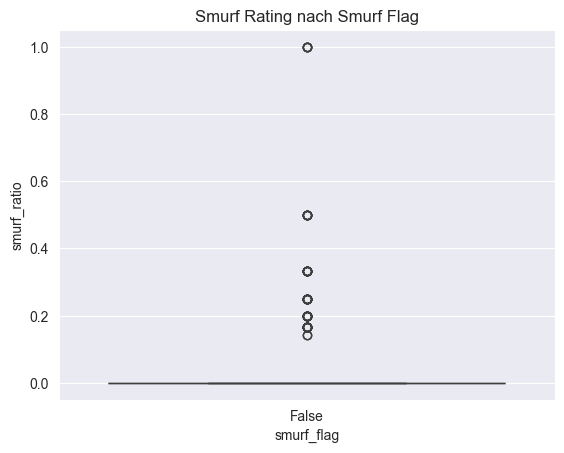

In [100]:
sns.boxplot(data=account_stats, x='smurf_flag', y='smurf_ratio')
plt.title('Smurf Rating nach Smurf Flag')

In [101]:
for t in [0.8, 1.0, 1.2, 1.5]:
    temp_flag = account_stats['smurf_ratio'] > t
    print(f"Threshold {t:.1f}:\n", pd.crosstab(account_stats['smurf_flag'], temp_flag, normalize='index'), "\n")

def label_smurf(row):
    if row['smurf_ratio'] >= 1.5:
        return 'definite_smurf'
    elif row['smurf_ratio'] >= 1.0:
        return 'likely_smurf'
    elif row['smurf_ratio'] >= 0.8:
        return 'possible_smurf'
    else:
        return 'normal'

account_stats['smurf_category'] = account_stats.apply(label_smurf, axis=1)
df_ranked = df_ranked.merge(account_stats[['puuid', 'smurf_category']], on='puuid', how='left')

Threshold 0.8:
 smurf_ratio     False     True 
smurf_flag                     
False        0.994786  0.005214 

Threshold 1.0:
 smurf_ratio  False
smurf_flag        
False          1.0 

Threshold 1.2:
 smurf_ratio  False
smurf_flag        
False          1.0 

Threshold 1.5:
 smurf_ratio  False
smurf_flag        
False          1.0 



In [102]:
#3. Rank Progression (von Iron zu Gold in unter <50 Spielen)
df_sorted = df_ranked.sort_values(['puuid', 'timestamp'])

def check_schneller_rank_aufstieg(gruppe):
    if len(gruppe) < 2:
        return False
    lowest_tier = gruppe['tier_num'].min()
    highest_tier = gruppe['tier_num'].max()
    num_games = len(gruppe)
    is_schnell_aufgestiegen = (lowest_tier == 1) and (highest_tier >= 4) and (num_games <= 50)
    return is_schnell_aufgestiegen

rankprog_df = df_sorted.groupby('puuid').apply(lambda x: check_schneller_rank_aufstieg(x)).reset_index()
rankprog_df.columns = ['puuid', 'fast_rank_progression']

df_ranked = df_ranked.merge(rankprog_df, on='puuid', how='left')

print(df_ranked[df_ranked['fast_rank_progression']])

Empty DataFrame
Columns: [timestamp, gameId, gameMode, gameType, tier, rank, LP, wins, losses, PlayerScore0, PlayerScore1, PlayerScore10, PlayerScore11, PlayerScore2, PlayerScore3, PlayerScore4, PlayerScore5, PlayerScore6, PlayerScore7, PlayerScore8, PlayerScore9, allInPings, assistMePings, assists, baronKills, basicPings, champExperience, champLevel, championId, championName, championSkinId, championTransform, commandPings, consumablesPurchased, damageDealtToBuildings, damageDealtToObjectives, damageDealtToTurrets, damageSelfMitigated, dangerPings, deaths, detectorWardsPlaced, doubleKills, dragonKills, eligibleForProgression, enemyMissingPings, enemyVisionPings, firstBloodAssist, firstBloodKill, firstTowerAssist, firstTowerKill, gameEndedInEarlySurrender, gameEndedInSurrender, getBackPings, goldEarned, goldSpent, holdPings, individualPosition, inhibitorKills, inhibitorTakedowns, inhibitorsLost, item0, item1, item2, item3, item4, item5, item6, itemsPurchased, killingSprees, kills, lane

C:\Users\Emret\AppData\Local\Temp\ipykernel_10620\3367400619.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rankprog_df = df_sorted.groupby('puuid').apply(lambda x: check_schneller_rank_aufstieg(x)).reset_index()


In [103]:
#6 Wie viele Perfekte Games (keine Tode)

perfect_games = df[df['deaths'] == 0]
perfect_games_won = perfect_games[perfect_games['win'] == True]

print(f"Anzahl Perfekte Games (keine Tode): {len(perfect_games)}")
print(f"… davon gewonnen: {len(perfect_games_won)}")

print(df_ranked[['puuid', 'perfectGame']])

#  Nicht notwendig ist schon im ranked_df

Anzahl Perfekte Games (keine Tode): 31
… davon gewonnen: 25
                                                 puuid  perfectGame
0    t1wLPAdlaN1kGqSczdNGQM0QSX6YCUcNeo-txsoRb0VDHE...            0
1    LPc53ZSIttQ4NdIhADztijUhGEM08WjM0Hoq_HtZeDJVKp...            0
2    abe3oIlqRT23zn-gOsw6qq23EnGDfo02myD8PjE0qy7hV7...            0
3    vHvSx0WmVUrlWKAVEBpkUH6I1HFka38wmHs--BfLslJFwM...            0
4    iYl1JJtyxSPpObh5iwZgk9fF8RuJPU0oY5Qs_3QP32o_kN...            0
..                                                 ...          ...
956  01_eMkc6MDQY-h5GHaBk2RAPFCXyHbiicD9D_2oGApDfsB...            0
957  zJ_HgkRT-BKy3vhBIcldIfEEhiH9P002TMEOI8zwp3Y9ps...            0
958  -jGSS5L-hY3myzWRCaVlaJalLopnbn9e1tEGYJplk1f8Ud...            0
959  etXiUGyXP4JsC-eickwwcFQulagWeTpXQBtNk_YjXxVx_C...            0
960  RM8YorftxA09zRzrec0b1F5ADOnomYLdHb2TJ7vXE1f2ei...            0

[961 rows x 2 columns]


In [104]:
#7 durchschnittlicher CS-Lead zum Lane Opponent --> Keine negativen Werte --> Nur Advantage

cs_lead_per_account = df.groupby('puuid')['maxCsAdvantageOnLaneOpponent'].mean().reset_index()
cs_lead_per_account.rename(columns={'maxCsAdvantageOnLaneOpponent': 'avg_cs_lead_lane'}, inplace=True)

df_ranked = df_ranked.merge(cs_lead_per_account, on='puuid', how='left')

print(df_ranked[['puuid', 'avg_cs_lead_lane']].head())

                                               puuid  avg_cs_lead_lane
0  t1wLPAdlaN1kGqSczdNGQM0QSX6YCUcNeo-txsoRb0VDHE...               0.0
1  LPc53ZSIttQ4NdIhADztijUhGEM08WjM0Hoq_HtZeDJVKp...               4.0
2  abe3oIlqRT23zn-gOsw6qq23EnGDfo02myD8PjE0qy7hV7...               1.0
3  vHvSx0WmVUrlWKAVEBpkUH6I1HFka38wmHs--BfLslJFwM...              49.2
4  iYl1JJtyxSPpObh5iwZgk9fF8RuJPU0oY5Qs_3QP32o_kN...               5.0


In [105]:
#8 hohe Vision Control Score

vision_score_thresholds = df.groupby('tier')['visionScore'].quantile(0.75).reset_index()
vision_score_thresholds.rename(columns={'visionScore': 'visionScore_threshold'}, inplace=True)

df_ranked = df_ranked.merge(vision_score_thresholds, on='tier', how='left')

df_ranked['high_vision_control'] = (
    (df_ranked['visionScore'] > df_ranked['visionScore_threshold']) &
    (df_ranked['visionScoreAdvantageLaneOpponent'] > 0.5)
)

print(df_ranked[['puuid', 'championName', 'tier', 'visionScore', 'visionScore_threshold', 'visionScoreAdvantageLaneOpponent', 'high_vision_control']].head())


                                               puuid championName     tier  \
0  t1wLPAdlaN1kGqSczdNGQM0QSX6YCUcNeo-txsoRb0VDHE...         Ekko  DIAMOND   
1  LPc53ZSIttQ4NdIhADztijUhGEM08WjM0Hoq_HtZeDJVKp...       Thresh  EMERALD   
2  abe3oIlqRT23zn-gOsw6qq23EnGDfo02myD8PjE0qy7hV7...  Mordekaiser  EMERALD   
3  vHvSx0WmVUrlWKAVEBpkUH6I1HFka38wmHs--BfLslJFwM...         Udyr  DIAMOND   
4  iYl1JJtyxSPpObh5iwZgk9fF8RuJPU0oY5Qs_3QP32o_kN...         Ashe  DIAMOND   

   visionScore  visionScore_threshold  visionScoreAdvantageLaneOpponent  \
0           27                   30.0                          0.141876   
1           87                   29.0                          0.161179   
2           21                   29.0                         -0.108931   
3           24                   30.0                         -0.124248   
4           22                   30.0                          0.153270   

   high_vision_control  
0                False  
1                False  
2    

In [114]:
#9 durchschnittliches Gold pro Minute bei Champ und Rolle
#--> Webseite scrapen für Rundendauer durchschnitt und mit durchschnitt von Gold/XP vergleichen
#--> https://op.gg/de/lol/statistics/champions und https://www.leagueofgraphs.com/stats/game-durations

with open("champtier.html", encoding="utf-8") as f:
    html = f.read()

soup = BeautifulSoup(html, "html.parser")

champ_data = []

rows = soup.find_all('tr')

for row in rows:
    cols = row.find_all('td')
    if len(cols) < 9:
        continue
    name = cols[1].text.strip()
    cs = cols[7].text.strip().replace(',', '.')
    gold = cols[8].text.strip().replace(',', '.')
    champ_data.append({'championName': name, 'goldAvgInternet': gold, 'csAvgInternet': cs})

for c in champ_data:
    print(c)

{'championName': 'Lux', 'goldAvgInternet': '10.702', 'csAvgInternet': '101.69'}
{'championName': 'Jhin', 'goldAvgInternet': '12.856', 'csAvgInternet': '187.62'}
{'championName': 'Caitlyn', 'goldAvgInternet': '12.863', 'csAvgInternet': '193.76'}
{'championName': 'Senna', 'goldAvgInternet': '11.423', 'csAvgInternet': '131.56'}
{'championName': 'Miss Fortune', 'goldAvgInternet': '12.945', 'csAvgInternet': '185.37'}
{'championName': 'Jinx', 'goldAvgInternet': '12.557', 'csAvgInternet': '196.68'}
{'championName': 'Yasuo', 'goldAvgInternet': '12.499', 'csAvgInternet': '201.57'}
{'championName': 'Ezreal', 'goldAvgInternet': '12.130', 'csAvgInternet': '187.82'}
{'championName': "Kai'Sa", 'goldAvgInternet': '13.038', 'csAvgInternet': '199.57'}
{'championName': 'Lucian', 'goldAvgInternet': '12.735', 'csAvgInternet': '200.26'}
{'championName': 'Yone', 'goldAvgInternet': '12.165', 'csAvgInternet': '197.42'}
{'championName': 'Pantheon', 'goldAvgInternet': '11.652', 'csAvgInternet': '126.64'}
{'cham

In [107]:
#9 durchschnittliches Gold pro Minute bei Champ und Rolle -- Continuation
def clean_name(name):
    if pd.isna(name):
        return ""
    return re.sub(r'[^A-Za-z0-9]', '', name).upper()

champion_gold_df = pd.DataFrame(champ_data)

#Unify championName
champion_gold_df['championName'] = champion_gold_df['championName'].apply(clean_name)
df_ranked['championName']      = df_ranked['championName'].apply(clean_name)
df_ranked['tier']              = df_ranked['tier'].str.strip().str.upper()

champion_gold_df['goldAvgInternet'] = (
    champion_gold_df['goldAvgInternet']
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

#Average gametime per rank
def compute_time(x: float) -> float:
    m = int(x)
    s = int((x - m) * 100)
    return (m*60 + s) / 60.0

Ranked_Solo_Duo = {
    tier: compute_time(val)
    for tier, val in {
        'IRON':   30.36, 'BRONZE': 30.44, 'SILVER': 30.33,
        'GOLD':   30.05, 'PLATINUM':29.32, 'EMERALD':28.54,
        'DIAMOND':28.02, 'MASTER':26.58, 'GRANDMASTER':26.36,
        'CHALLENGER':26.11
    }.items()
}

df_ranked = df_ranked.merge(
    champion_gold_df[['championName','goldAvgInternet']],
    on='championName',
    how='left'
)

df_ranked['avgGameTime'] = df_ranked['tier'].map(Ranked_Solo_Duo)

df_ranked['internetGoldPerMinute'] = (
    df_ranked['goldAvgInternet'] / df_ranked['avgGameTime']
)

df_ranked['gpmDelta'] = df_ranked['goldPerMinute'] - df_ranked['internetGoldPerMinute']

display(df_ranked[['puuid','championName','tier',
                   'goldAvgInternet','avgGameTime',
                   'internetGoldPerMinute','goldPerMinute','gpmDelta']].head(10))

,puuid,championName,tier,goldAvgInternet,avgGameTime,internetGoldPerMinute,goldPerMinute,gpmDelta
0,t1wLPAdlaN1kGqSczdNGQM0QSX6YCUcNeo-txsoRb0VDHE...,EKKO,DIAMOND,12785.0,28.016667,456.335515,392.003920,-64.331595
1,LPc53ZSIttQ4NdIhADztijUhGEM08WjM0Hoq_HtZeDJVKp...,THRESH,EMERALD,8633.0,28.883333,298.892095,268.501090,-30.391005
2,abe3oIlqRT23zn-gOsw6qq23EnGDfo02myD8PjE0qy7hV7...,MORDEKAISER,EMERALD,12051.0,28.883333,417.230237,265.403419,-151.826818
3,vHvSx0WmVUrlWKAVEBpkUH6I1HFka38wmHs--BfLslJFwM...,UDYR,DIAMOND,12177.0,28.016667,434.634146,480.378999,45.744853
4,iYl1JJtyxSPpObh5iwZgk9fF8RuJPU0oY5Qs_3QP32o_kN...,ASHE,DIAMOND,11599.0,28.016667,414.003569,382.751344,-31.252226
5,K6Zlv4dExa9Kjr7_jWoIj70Ama_oqCjdbLxt62vu4882Ea...,SHYVANA,EMERALD,12801.0,28.883333,443.196769,568.891786,125.695018
6,TcMyuKW2i_XdrNz71vBmB5EvjD7Vm11T91dVzZLrS-RPPi...,VARUS,PLATINUM,12352.0,29.533333,418.239278,534.872225,116.632948
7,q9r2CSTVhQMRFqf8NhAIpzvVHhkeCUCntzIF68kx_b_CCF...,IRELIA,DIAMOND,13203.0,28.016667,471.255205,385.569859,-85.685346
8,zV8mprquDgFOOPyZG5XzzsII5j1r0uI1KCG-LNhRnd1JuZ...,ELISE,SILVER,11474.0,30.533333,375.786026,320.482666,-55.303360
9,RV8zGlBgTntEB-hrhQV4_K5TZ5tZpCTHtQDh0oSXhuijk2...,SIVIR,PLATINUM,12949.0,29.533333,438.453725,380.917706,-57.536018


In [108]:
#10. Zeit bis first full Item

#There is no possible metric for first full Item
#However we could estimate the first item time by applying the goldPerMinute feature on the first bought item cost

url = 'https://wiki.leagueoflegends.com/en-us/List_of_items'
r = requests.get(url)
soup = BeautifulSoup(r.text, "html.parser")

#Search for legendary items and their URLs

item_names = []
item_links = []
legendary_items = []

for dt in soup.find_all('dt'):
    if "Legendary items" in dt.text:
        legendary_div = dt.find_next('div', class_='tlist')
        if legendary_div:
            for item in legendary_div.find_all('li'):
                icon_div = item.find('div', class_='item-icon')
                if icon_div:
                    name = icon_div.get('data-item', '')
                    a_tag = item.find('a', href=True)
                    link = 'https://wiki.leagueoflegends.com' + a_tag['href'] if a_tag else ''
                    item_names.append(name)
                    item_links.append(link)
        break

#Visit every URL and find out what the item cost and ID is

for i in range(len(item_links)):
    url = item_links[i]
    r = requests.get(url)
    soup = BeautifulSoup(r.text, "html.parser")

    infobox = soup.find('div', class_='infobox-section-cell')

    cost = ''
    item_id = ''
    if infobox:
        rows = infobox.find_all('div', class_='infobox-data-row')
        for row in rows:
            label = row.find('div', class_='infobox-data-label')
            value = row.find('div', class_='infobox-data-value')
            if not label or not value:
                continue
            # Extract item costs
            if 'Cost' in label.text:
                gold_span = value.find('span', style=lambda x: x and 'color:#E2BA3D' in x)
                if gold_span:
                    cost_text = gold_span.find_all('span')[-1].text.strip()
                    cost = cost_text
            # Extract item ID
            if label.text.strip() == 'ID':
                item_id = value.text.strip()
    legendary_items.append({'name': item_names[i], 'cost': cost, 'id': item_id})

print(legendary_items)

[{'name': 'Abyssal Mask', 'cost': '2650', 'id': '8020'}, {'name': "Archangel's Staff", 'cost': '2900', 'id': '3003'}, {'name': 'Ardent Censer', 'cost': '2200', 'id': '3504'}, {'name': 'Axiom Arc', 'cost': '3000', 'id': '6696'}, {'name': "Banshee's Veil", 'cost': '3000', 'id': '3102'}, {'name': 'Black Cleaver', 'cost': '3000', 'id': '3071'}, {'name': 'Blackfire Torch', 'cost': '2800', 'id': '2503'}, {'name': 'Blade of the Ruined King', 'cost': '3200', 'id': '3153'}, {'name': "Bloodletter's Curse", 'cost': '2900', 'id': '8010'}, {'name': 'Bloodsong', 'cost': '400', 'id': '3877'}, {'name': 'Bloodthirster', 'cost': '3400', 'id': '3072'}, {'name': 'Bounty of Worlds', 'cost': '400', 'id': '3867'}, {'name': 'Celestial Opposition', 'cost': '400', 'id': '3869'}, {'name': 'Chempunk Chainsword', 'cost': '3100', 'id': '6609'}, {'name': 'Cosmic Drive', 'cost': '3000', 'id': '4629'}, {'name': 'Cryptbloom', 'cost': '3000', 'id': '3137'}, {'name': 'Dawncore', 'cost': '2500', 'id': '6621'}, {'name': "D

In [109]:
#10. Zeit bis first full Item - Continuation

#if item_id in items, then we take the first entry and take the costs and look how much gold per minute he has

id_to_cost = {str(item['id']): int(item['cost']) for item in legendary_items if 'id' in item and 'cost' in item}
print(id_to_cost)

legendary_ids = set(id_to_cost.keys())

def first_legendary_stats(row):
    items = [str(row[f'item{i}']) for i in range(7) if f'item{i}' in row]
    for item in items:
        if item in legendary_ids:
            cost = id_to_cost[item]
            if cost >= 500:  # Filter out evolved support items, because they cost 400G and count as legendary
                gpm = row['goldPerMinute']
                minutes_needed = round(cost / gpm, 2) if gpm > 0 else None
                return pd.Series({
                    'first_legendary_id': item,
                    'first_legendary_cost': cost,
                    'first_legendary_minutes': minutes_needed
                })
    return pd.Series({'first_legendary_id': None, 'first_legendary_cost': None, 'first_legendary_minutes': None})

# Apply auf DataFrame:
df_ranked = df_ranked.join(df_ranked.apply(first_legendary_stats, axis=1))

print(df_ranked[['puuid','first_legendary_id', 'first_legendary_cost', 'first_legendary_minutes']].head(20))

{'8020': 2650, '3003': 2900, '3504': 2200, '6696': 3000, '3102': 3000, '3071': 3000, '2503': 2800, '3153': 3200, '8010': 2900, '3877': 400, '3072': 3400, '3867': 400, '3869': 400, '6609': 3100, '4629': 3000, '3137': 3000, '6621': 2500, '3742': 2900, '6333': 3300, '3870': 400, '6620': 2200, '6692': 2900, '3814': 3000, '3508': 2900, '3073': 3000, '3121': 2400, '4401': 2800, '3110': 2500, '3026': 3200, '3124': 3000, '3084': 3000, '3152': 2650, '6664': 2800, '4628': 2800, '6697': 3000, '3181': 3000, '6662': 2900, '6673': 3000, '4005': 2250, '3031': 3450, '6665': 3200, '2504': 2900, '3109': 2300, '6672': 3100, '6653': 3000, '3100': 2900, '3190': 2200, '3036': 3100, '6655': 2750, '3118': 2700, '3004': 2900, '3156': 3100, '3041': 1500, '3139': 3200, '3222': 2300, '6617': 2200, '3165': 2850, '3033': 3300, '3042': 2900, '3115': 2900, '6675': 2650, '6701': 2700, '2501': 3300, '3046': 2650, '6698': 3200, '3089': 3500, '3143': 2700, '3094': 2650, '3074': 3300, '3107': 2300, '4633': 3100, '6657': 2

In [113]:
#12. Off-Meta Champs

with open("champ-stats.html", encoding="utf-8") as f:
    html = f.read()

soup = BeautifulSoup(html, "html.parser")

color_to_tier = {
    "#0093ff": "1",
    "#00bba3": "2",
    "#ffb900": "3",
    "#9aa4af": "4",
    "#a88a67": "5"
}

champ_data_tier = []

rows = soup.find_all('tr')

for row in rows:
    cols = row.find_all('td')
    if len(cols) < 8:
        continue
    tier = None
    svg_tag_tier = cols[2].find('svg')
    if svg_tag_tier:
        path_tag_tier = svg_tag_tier.find('path')
        if path_tag_tier and path_tag_tier.has_attr('fill'):
            color = path_tag_tier['fill'].lower()
            tier = color_to_tier.get(color)

    role = None
    svg_tag_role = cols[3].find('svg')
    if svg_tag_role:
        for path_tag_role in svg_tag_role.find_all('path'):
            d_code = path_tag_role.get('d', '').lower().strip()
            opacity = path_tag_role.get('opacity')
            # BOT/TOP Sonderfall:
            if d_code == "m19 3-4 4h7v8l-4 4v3z":
                if opacity == "0.2":
                    role = "BOT"
                else:
                    role = "TOP"
                break
            # Jungle
            elif "m5.14 2c1.58" in d_code:
                role = "JUNGLE"
                break
            # Mid
            elif "m15 3-4 4h7v4l-4 4v3z" in d_code:
                role = "MID"
                break
            # Utility
            elif "m12.833 10.833" in d_code or "14.5 17.53" in d_code:
                role = "UTILITY"
                break

    name_a = cols[1].find("a")
    name = name_a.text.strip() if name_a else cols[1].text.strip()
    winrate = cols[4].text.strip() if len(cols) > 4 else ""
    pickrate = cols[5].text.strip() if len(cols) > 5 else ""
    champ_data_tier.append({
        'champion': name,
        'role': role,
        'tier': tier,
        'winrate': winrate,
        'pickrate': pickrate
    })
for c in champ_data_tier:
    print(c)

{'champion': 'Trundle', 'role': 'JUNGLE', 'tier': '1', 'winrate': '53.27%', 'pickrate': '3.58%'}
{'champion': 'Sett', 'role': 'TOP', 'tier': '1', 'winrate': '52.69%', 'pickrate': '9.72%'}
{'champion': 'Milio', 'role': 'UTILITY', 'tier': '1', 'winrate': '52.64%', 'pickrate': '5.75%'}
{'champion': 'Warwick', 'role': 'JUNGLE', 'tier': '1', 'winrate': '52.45%', 'pickrate': '7.26%'}
{'champion': 'Yorick', 'role': 'TOP', 'tier': '1', 'winrate': '52.4%', 'pickrate': '6.25%'}
{'champion': 'Mordekaiser', 'role': 'TOP', 'tier': '1', 'winrate': '52.37%', 'pickrate': '7.07%'}
{'champion': 'Kayle', 'role': 'TOP', 'tier': '1', 'winrate': '52.29%', 'pickrate': '4.66%'}
{'champion': 'Volibear', 'role': 'JUNGLE', 'tier': '1', 'winrate': '52.24%', 'pickrate': '4.96%'}
{'champion': 'Nami', 'role': 'UTILITY', 'tier': '1', 'winrate': '52.15%', 'pickrate': '9.14%'}
{'champion': 'Nocturne', 'role': 'JUNGLE', 'tier': '1', 'winrate': '52.06%', 'pickrate': '8.99%'}
{'champion': 'Malzahar', 'role': 'MID', 'tier'

In [115]:
#12. Off-Meta Champs -- Continuation
#If champ is tier 4 or 5 and pickrate is <1% then it is called off meta
#If champ + role combo is not in the list --> OffMeta too

meta_df = pd.DataFrame(champ_data_tier)

meta_df['pickrate_float'] = meta_df['pickrate'].str.replace('%', '').str.replace(',', '.').astype(float)

valid_combos = set(zip(meta_df['champion'], meta_df['role']))

def is_offmeta(row):
    champ = row['championName']
    role = row['teamPosition']
    meta_row = meta_df[(meta_df['champion'] == champ) & (meta_df['role'] == role)]
    if (champ, role) not in valid_combos:
        return True
    if not meta_row.empty:
        tier = meta_row.iloc[0]['tier']
        pickrate = meta_row.iloc[0]['pickrate_float']
        if (tier in ['4', '5']) and (pickrate < 1):
            return True
    return False

df_ranked['offmeta'] = df_ranked.apply(is_offmeta, axis=1)
display(df_ranked[["offmeta","puuid"]])

,offmeta,puuid
0,True,t1wLPAdlaN1kGqSczdNGQM0QSX6YCUcNeo-txsoRb0VDHE...
1,True,LPc53ZSIttQ4NdIhADztijUhGEM08WjM0Hoq_HtZeDJVKp...
2,True,abe3oIlqRT23zn-gOsw6qq23EnGDfo02myD8PjE0qy7hV7...
3,True,vHvSx0WmVUrlWKAVEBpkUH6I1HFka38wmHs--BfLslJFwM...
4,True,iYl1JJtyxSPpObh5iwZgk9fF8RuJPU0oY5Qs_3QP32o_kN...
...,...,...
956,True,01_eMkc6MDQY-h5GHaBk2RAPFCXyHbiicD9D_2oGApDfsB...
957,True,zJ_HgkRT-BKy3vhBIcldIfEEhiH9P002TMEOI8zwp3Y9ps...
958,True,-jGSS5L-hY3myzWRCaVlaJalLopnbn9e1tEGYJplk1f8Ud...
959,True,etXiUGyXP4JsC-eickwwcFQulagWeTpXQBtNk_YjXxVx_C...


In [117]:
#13. Anteil der Spiele mit über 20 Kills

kills_threshold = 20

games_with_over_kills = df_ranked.groupby('puuid')['kills'].apply(lambda x: (x > kills_threshold).mean()).reset_index()
games_with_over_kills.rename(columns={'kills': f'rate_games_over_{kills_threshold}kills'}, inplace=True)

df_ranked = df_ranked.merge(games_with_over_kills, on='puuid', how='left')

print(df_ranked[['puuid', f'rate_games_over_{kills_threshold}kills']].head())


KeyError: "['rate_games_over_20kills'] not in index"

In [118]:
#17 Durchschnittliche Anzahl an "Skillshots landed" und dodged
#Dictionary für jedes Rank wie viel Skillshots landed --> Yes/No

avg_skillshots_per_rank = df.groupby('tier')['skillshotsHit'].mean().reset_index()
avg_skillshots_per_rank.rename(columns={'skillshotsHit': 'avg_skillshots_hit'}, inplace=True)

avg_skillshots_dodged_per_rank = df.groupby('tier')['skillshotsDodged'].mean().reset_index()
avg_skillshots_dodged_per_rank.rename(columns={'skillshotsDodged': 'avg_skillshots_dodged'}, inplace=True)

player_skillshots = df.groupby(['puuid', 'tier'])['skillshotsHit'].mean().reset_index()
player_skillshots.rename(columns={'skillshotsHit': 'player_skillshots'}, inplace=True)

player_skillshots_dodged = df.groupby(['puuid', 'tier'])['skillshotsDodged'].mean().reset_index()
player_skillshots_dodged.rename(columns={'skillshotsDodged': 'player_dodged'}, inplace=True)

avg_combined_skillshots = avg_skillshots_per_rank.merge(avg_skillshots_dodged_per_rank, on='tier', how='left')

compare_skillshots = player_skillshots.merge(
    avg_skillshots_per_rank, on=['tier'], how='left'
    ).merge(
        player_skillshots_dodged, on=['puuid', 'tier'], how='left'
    ).merge(
        avg_skillshots_dodged_per_rank, on=['tier'], how='left'
    )

compare_skillshots['skillshots_above_rank'] = np.where(
    compare_skillshots['player_skillshots'] > compare_skillshots['avg_skillshots_hit'], 1, 0
)

compare_skillshots['dodged_above_rank'] = np.where(
    compare_skillshots['player_dodged'] > compare_skillshots['avg_skillshots_dodged'], 1, 0
)

df_ranked = df_ranked.merge(compare_skillshots[['puuid',
                            'tier',
                            'player_skillshots',
                            'avg_skillshots_hit',
                            'skillshots_above_rank',
                            'player_dodged',
                            'avg_skillshots_dodged',
                            'dodged_above_rank'
                        ]], on=['puuid', 'tier'],
                        how='left'
                    )

print(df_ranked[[
    'puuid',
    'tier',
    'player_skillshots',
    'avg_skillshots_hit',
    'skillshots_above_rank',
    'player_dodged',
    'avg_skillshots_dodged',
    'dodged_above_rank'
]].head())

#print(avg_skillshots_per_rank)
#print(player_skillshots)
#print(avg_skillshots_dodged_per_rank)
#print(avg_combined_skillshots)

                                               puuid     tier  \
0  t1wLPAdlaN1kGqSczdNGQM0QSX6YCUcNeo-txsoRb0VDHE...  DIAMOND   
1  LPc53ZSIttQ4NdIhADztijUhGEM08WjM0Hoq_HtZeDJVKp...  EMERALD   
2  abe3oIlqRT23zn-gOsw6qq23EnGDfo02myD8PjE0qy7hV7...  EMERALD   
3  vHvSx0WmVUrlWKAVEBpkUH6I1HFka38wmHs--BfLslJFwM...  DIAMOND   
4  iYl1JJtyxSPpObh5iwZgk9fF8RuJPU0oY5Qs_3QP32o_kN...  DIAMOND   

   player_skillshots  avg_skillshots_hit  skillshots_above_rank  \
0               37.0           32.764151                      1   
1               13.0           29.239130                      0   
2                0.0           29.239130                      0   
3                0.0           32.764151                      0   
4               63.0           32.764151                      1   

   player_dodged  avg_skillshots_dodged  dodged_above_rank  
0           69.0              39.056604                  1  
1          104.0              29.717391                  1  
2          103.0       

In [119]:
#18 Durchschnittliche Objective Steals pro Spiel
#Dictionary für jeden Rank wie viel Steals typisch sind. Wenn mehr --> Yes/No

avg_EpicMonsterSteals_per_rank = df.groupby('tier')['epicMonsterSteals'].mean().reset_index()
avg_EpicMonsterSteals_per_rank.rename(columns={'epicMonsterSteals': 'avg_epicMonsterSteals'}, inplace=True)

avg_EpicMonsterStolenWOsmite_per_rank = df.groupby('tier')['epicMonsterStolenWithoutSmite'].mean().reset_index()
avg_EpicMonsterStolenWOsmite_per_rank.rename(columns={'epicMonsterStolenWithoutSmite': 'avg_epicMonsterStolenWithoutSmite'}, inplace=True)

player_EpicMonsterSteals = df.groupby(['puuid', 'tier'])['epicMonsterSteals'].mean().reset_index()
player_EpicMonsterSteals.rename(columns={'epicMonsterSteals': 'player_epicMonsterSteals'}, inplace=True)

player_EpicMonsterStealsWOsmite = df.groupby(['puuid', 'tier'])['epicMonsterStolenWithoutSmite'].mean().reset_index()
player_EpicMonsterStealsWOsmite.rename(columns={'epicMonsterStolenWithoutSmite': 'player_epicMonsterStealsWOsmite'}, inplace=True)

compare_objectives = player_EpicMonsterSteals.merge(
    avg_EpicMonsterSteals_per_rank, on='tier', how='left'
).merge(
    player_EpicMonsterStealsWOsmite, on=['puuid', 'tier'], how='left'
).merge(
    avg_EpicMonsterStolenWOsmite_per_rank, on='tier', how='left'
)

compare_objectives['epicMonsterSteals_above_rank'] = np.where(
    compare_objectives['player_epicMonsterSteals'] > compare_objectives['avg_epicMonsterSteals'], 1, 0
)
compare_objectives['epicMonsterStealsWOsmite_above_rank'] = np.where(
    compare_objectives['player_epicMonsterStealsWOsmite'] > compare_objectives['avg_epicMonsterStolenWithoutSmite'], 1, 0
)

df_ranked = df_ranked.merge(compare_objectives[['puuid',
                            'tier',
                            'player_epicMonsterSteals',
                            'avg_epicMonsterSteals',
                            'player_epicMonsterStealsWOsmite',
                            'avg_epicMonsterStolenWithoutSmite',
                            'epicMonsterSteals_above_rank',
                            'epicMonsterStealsWOsmite_above_rank'
                        ]],
                        on=['puuid', 'tier'],
                        how='left'
                    )

#print(avg_EpicMonsterSteals_per_rank)
#print(avg_EpicMonsterStolenWOsmite_per_rank)

In [120]:
# 21 Erst Prüfen ob "eligibleForProgression" ist auf "True"
print(df['eligibleForProgression'])

21      True
24      True
25      True
26      True
28      True
        ... 
2103    True
2104    True
2105    True
2106    True
2107    True
Name: eligibleForProgression, Length: 967, dtype: bool


In [121]:
# Aufräumaktion
df_ranked = df_ranked.loc[:, ~df_ranked.columns.str.startswith('SWARM_')]
df_ranked = df_ranked.loc[:, ~df_ranked.columns.str.startswith('challenge_SWARM_')]
df_ranked = df_ranked.drop(columns=['championSkinId', 'perks_styles','summonerName','legendaryItemUsed','challenge_legendaryItemUsed', 'rank', 'tier', 'individualPosition','role'], errors='ignore')

In [122]:
# Bool'sche Werte in numerische umwandeln
df_ranked_bool = df_ranked.select_dtypes(include=['bool'])

df_ranked[df_ranked_bool.columns] = df_ranked_bool.map(lambda x: 1 if x else 0)

In [127]:
for x in ['hotStreak', 'veteran', 'freshBlood']:
    df_ranked[x] = df_ranked[x].map({'True': 1, 'False': 0})

df_ranked['first_legendary_id'] = df_ranked['first_legendary_id'].fillna(0)
df_ranked['first_legendary_id'] = df_ranked['first_legendary_id'].astype('int64')

df_ranked['lane'] = df_ranked['lane'].replace('NONE', 'FILL')

lanes = pd.get_dummies(df_ranked['lane'], prefix='queued_lane', dtype=int)

df_ranked = pd.concat([df_ranked, lanes], axis=1)


played_lane = pd.get_dummies(df_ranked['teamPosition'], prefix='played_lane', dtype=int)

df_ranked = pd.concat([df_ranked, played_lane], axis=1)


df_ranked = df_ranked.drop(['lane'], axis=1, errors='ignore')
df_ranked = df_ranked.drop(['teamPosition'], axis=1, errors='ignore')


df_ranked['timestamp'] = df_ranked['timestamp'].astype('int64')
df_ranked = df_ranked.rename(columns={'timestamp': 'gameCreationTimestamp'})

In [128]:
champions = {
    'ALISTAR': 1,
    'ANNIE': 2,
    'ASHE': 3,
    'FIDDLESTICKS': 4,
    'JAX': 5,
    'KAYLE': 6,
    'MASTER YI': 7,
    'MORGANA': 8,
    'NUNUWILLUMP': 9,
    'RYZE': 10,
    'SION': 11,
    'SIVIR': 12,
    'SORAKA': 13,
    'TEEMO': 14,
    'TRISTANA': 15,
    'TWISTEDFATE': 16,
    'WARWICK': 17,
    'SINGED': 18,
    'ZILEAN': 19,
    'EVELYNN': 20,
    'TRYNDAMERE': 21,
    'TWITCH': 22,
    'KARTHUS': 23,
    'AMUMU': 24,
    'CHOGATH': 25,
    'ANIVIA': 26,
    'RAMMUS': 27,
    'VEIGAR': 28,
    'KASSADIN': 29,
    'GANGPLANK': 30,
    'TARIC': 31,
    'BLITZCRANK': 32,
    'DRMUNDO': 33,
    'JANNA': 34,
    'MALPHITE': 35,
    'CORKI': 36,
    'KATARINA': 37,
    'NASUS': 38,
    'HEIMERDINGER': 39,
    'SHACO': 40,
    'UDYR': 41,
    'NIDALEE': 42,
    'POPPY': 43,
    'GRAGAS': 44,
    'PANTHEON': 45,
    'MORDEKAISER': 46,
    'EZREAL': 47,
    'SHEN': 48,
    'KENNEN': 49,
    'GAREN': 50,
    'AKALI': 51,
    'MALZAHAR': 52,
    'OLAF': 53,
    'KOGMAW': 54,
    'XINZHAO': 55,
    'VLADIMIR': 56,
    'GALIO': 57,
    'URGOT': 58,
    'MISSFORTUNE': 59,
    'SONA': 60,
    'SWAIN': 61,
    'LUX': 62,
    'LEBLANC': 63,
    'IRELIA': 64,
    'TRUNDLE': 65,
    'CASSIOPEIA': 66,
    'CAITLYN': 67,
    'RENEKTON': 68,
    'KARMA': 69,
    'MAOKAI': 70,
    'JARVANIV': 71,
    'NOCTURNE': 72,
    'LEESIN': 73,
    'BRAND': 74,
    'RUMBLE': 75,
    'VAYNE': 76,
    'ORIANNA': 77,
    'YORICK': 78,
    'LEONA': 79,
    'WUKONG': 80,
    'SKARNER': 81,
    'TALON': 82,
    'RIVEN': 83,
    'XERATH': 84,
    'GRAVES': 85,
    'SHYVANA': 86,
    'FIZZ': 87,
    'VOLIBEAR': 88,
    'AHRI': 89,
    'VIKTOR': 90,
    'SEJUANI': 91,
    'ZIGGS': 92,
    'NAUTILUS': 93,
    'FIORA': 94,
    'LULU': 95,
    'HECARIM': 96,
    'VARUS': 97,
    'DARIUS': 98,
    'DRAVEN': 99,
    'JAYCE': 100,
    'ZYRA': 101,
    'DIANA': 102,
    'RENGAR': 103,
    'SYNDRA': 104,
    'KHAZIX': 105,
    'ELISE': 106,
    'ZED': 107,
    'NAMI': 108,
    'VI': 109,
    'THRESH': 110,
    'QUINN': 111,
    'ZAC': 112,
    'LISSANDRA': 113,
    'AATROX': 114,
    'LUCIAN': 115,
    'JINX': 116,
    'YASUO': 117,
    'VELKOZ': 118,
    'BRAUM': 119,
    'GNAR': 120,
    'AZIR': 121,
    'KALISTA': 122,
    'REKSAI': 123,
    'BARD': 124,
    'EKKO': 125,
    'TAHMKENCH': 126,
    'KINDRED': 127,
    'ILLAOI': 128,
    'JHIN': 129,
    'AURELIONSOL': 130,
    'TALIYAH': 131,
    'KLED': 132,
    'IVERN': 133,
    'CAMILLE': 134,
    'RAKAN': 135,
    'XAYAH': 136,
    'KAYN': 137,
    'ORNN': 138,
    'ZOE': 139,
    'KAISA': 140,
    'PYKE': 141,
    'NEEKO': 142,
    'SYLAS': 143,
    'YUUMI': 144,
    'QIYANA': 145,
    'SENNA': 146,
    'APHELIOS': 147,
    'SETT': 148,
    'LILLIA': 149,
    'YONE': 150,
    'SAMIRA': 151,
    'SERAPHINE': 152,
    'RELL': 153,
    'VIEGO': 154,
    'GWEN': 155,
    'AKSHAN': 156,
    'VEX': 157,
    'ZERI': 158,
    'RENATAGLASC': 159,
    'BELVETH': 160,
    'NILAH': 161,
    'KSANTE': 162,
    'MILIO': 163,
    'NAAFIRI': 164,
    'BRIAR': 165,
    'HWEI': 166,
    'SMOLDER': 167,
    'AURORA': 168,
    'AMBESSA': 169,
    'MEL': 170
}

df_ranked['championName'] = df_ranked['championName'].map(champions)

In [129]:
df_ranked_obj = df_ranked.select_dtypes(include=['datetime64'])
df_ranked_obj

""
0
1
2
3
4
...
956
957
958
959


In [130]:
#Imputation

df_ranked = df_ranked.fillna(
    df_ranked
        .select_dtypes(
            include=['float64']
            )
            .mean()
            .fillna(0)
    )

df_ranked = df_ranked.fillna(
    df_ranked
        .select_dtypes(
            include=['int64']
            )
            .mode()
            .iloc[0]
            .fillna(0)
            )

In [131]:
df_ranked.dtypes.value_counts()

int64      337
float64    128
object       7
Name: count, dtype: int64

In [132]:
with open('features_columns_df_ranked.json', 'w', encoding='utf-8') as f:
    json.dump(list(df_ranked.columns), f, ensure_ascii=False, indent=2)

In [133]:
df_ranked.select_dtypes(include=['float64', 'int64']).columns

Index(['gameCreationTimestamp', 'gameId', 'LP', 'wins', 'losses',
       'PlayerScore0', 'PlayerScore1', 'PlayerScore10', 'PlayerScore11',
       'PlayerScore2',
       ...
       'queued_lane_BOTTOM', 'queued_lane_FILL', 'queued_lane_JUNGLE',
       'queued_lane_MIDDLE', 'queued_lane_TOP', 'played_lane_BOTTOM',
       'played_lane_JUNGLE', 'played_lane_MIDDLE', 'played_lane_TOP',
       'played_lane_UTILITY'],
      dtype='object', length=465)

In [134]:
df_ranked['smurf_flag'].value_counts()

smurf_flag
0    961
Name: count, dtype: int64

In [135]:
df_ranked.to_csv('df_eneemr.csv', index=False)